In [1]:
%matplotlib inline
import os, sys, glob
import numpy as np
from matplotlib import pyplot as plt
#
sys.path.append('/home/fpoitevi/notebooks/cryo_home/slaclab/cryoEM-notebooks/src/')
import simutils
import cryoemio
import dmutils
import imutils

In [2]:
SIMULATIONDIR='/gpfs/slac/cryo/fs1/g/ML/cryoEM-notebooks/data/Simulation/synthetic_datasets/'
DATADIR = SIMULATIONDIR+'randomrot1D_multiPDB/'
#DATADIR = '/Users/mtrigo/Documents/cryoEM/randomrot1D/'

In [3]:
## 
binning = 4
## define the parameters for the DM
b = 150
sigma2 = 6e6
alpha = 1

In [22]:
## load data and bin images
filelist = glob.glob(DATADIR+"3j9z*_no_noise.h5")
particles   = []
defocus     = []
coordinates = []
for file in filelist:
    dic = cryoemio.load_dict_from_hdf5(file) # load dictionary
    # PARTICLES
    data = dic['data']                                      # extract 
    n_particles = data.shape[0]                             #
    binned_data = imutils.binstack(data, bin_size=binning)  # bin 
    particles.append(binned_data)                           # append to dataset
    # DEFOCUS
    data = dic['optics']['defocus_nominal']                 # extract
    extended_data = [ data for i in range(n_particles) ]    # assign to each particle
    defocus.append(extended_data)                           # append to dataset
    # COORDINATES
    data = dic['coordinates']                               # extract
    coordinates.append(data)                                # append to dataset
particles   = np.array(particles)
particles   = particles.reshape( (particles.shape[0]*particles.shape[1],particles.shape[2],particles.shape[3]) )
defocus     = np.array(defocus)
defocus     = defocus.reshape( (defocus.shape[0]*defocus.shape[1]) )
coordinates = np.array(coordinates)
coordinates = coordinates.reshape( (coordinates.shape[0]*coordinates.shape[1],coordinates.shape[2]) )

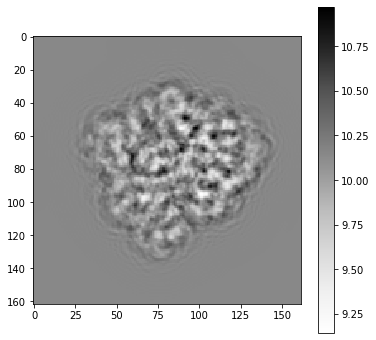

In [23]:
fig = plt.figure(figsize=(6,6))
plt.imshow(particles[10,...], cmap='Greys')
plt.colorbar()

In [24]:
particles.shape

(2880, 162, 162)

In [25]:
W = dmutils.dm_affinity_matrix(particles.reshape(particles.shape[0],particles.shape[1]*particles.shape[2]), b, sigma2, alpha)

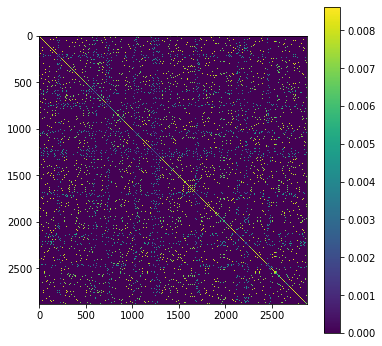

In [26]:
fig = plt.figure(figsize=(6,6))
plt.imshow(W)
plt.colorbar()

In [27]:
from scipy.linalg import svd
U,s,V = svd(W,full_matrices=False)
U = U/U[:,0]

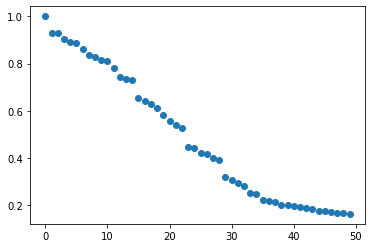

In [29]:
# pyl.plot(np.log(s),'o')
plt.plot(s[0:50],'o')

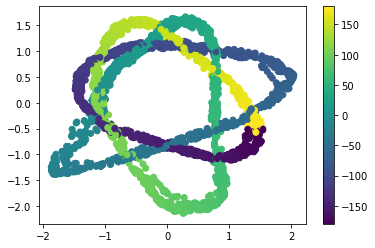

In [35]:
ii1=1
ii2=2
plt.scatter(U[:,ii1], U[:,ii2], c=coordinates[:,3])
#plt.scatter(U[:,ii1], U[:,ii2], c=defocus)
plt.colorbar()